In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader
from wilds.common.grouper import CombinatorialGrouper
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np

from erm_helpers import *
from Classifier import Classifier
from SubsampledDataset import SubsampledDataset, NUM_CLASSES


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# device = "cpu"
BATCH_SIZE = 8

cuda


<font size="6">Load train and validation data</font>

In [2]:
dataset = get_dataset(dataset="fmow", download=False)
grouper = CombinatorialGrouper(dataset, ["region"])

train_data = dataset.get_subset(
		"train",
	  transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

ood_val_data = dataset.get_subset(
    "val",
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

id_val_data = dataset.get_subset(
    "id_val",
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

train_dataset = SubsampledDataset(train_data, grouper)
ood_val_dataset = SubsampledDataset(ood_val_data, grouper)
id_val_dataset = SubsampledDataset(id_val_data, grouper)

train_loader = get_train_loader("standard", train_dataset, batch_size=BATCH_SIZE)
ood_val_loader = get_train_loader("standard", ood_val_dataset, batch_size=BATCH_SIZE)
id_val_loader = get_train_loader("standard", id_val_dataset, batch_size=BATCH_SIZE)

In [3]:
torch.save(train_dataset, 'subsampled_data/train_dataset.pth')
torch.save(ood_val_dataset, 'subsampled_data/ood_val_dataset.pth')
torch.save(id_val_dataset, 'subsampled_data/id_val_dataset.pth')

In [4]:
dataset = get_dataset(dataset="fmow", download=False)

train_dataset = torch.load('subsampled_data/train_dataset.pth')
ood_val_dataset = torch.load('subsampled_data/ood_val_dataset.pth')
id_val_dataset = torch.load('subsampled_data/id_val_dataset.pth')

train_loader = get_train_loader("standard", train_dataset, batch_size=BATCH_SIZE)
ood_val_loader   = get_train_loader("standard", ood_val_dataset, batch_size=BATCH_SIZE)
id_val_loader    = get_train_loader("standard", id_val_dataset, batch_size=BATCH_SIZE)

<font size="6">Train and accumulate evaluation per epoch</font>

In [15]:
for _ in tqdm(range(2*min(len(train_loader), len(ood_val_loader)))):
  pass

100%|██████████| 1452/1452 [00:00<00:00, 2251434.16it/s]


In [7]:
for _ in tqdm(range(10)):
  pass

100%|██████████| 10/10 [00:00<00:00, 221920.85it/s]


In [18]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, unet_loader, unet_loss_fn, unet_optimizer):
  model.train()

  accumulated_y_true = torch.tensor([]).to(device)
  accumulated_y_pred = torch.tensor([]).to(device)
  accumulated_metadata = torch.tensor([]).to(device)
  loss_value = 0

  loader_iter = iter(data_loader)
  unet_iter = iter(unet_loader)
  for i in tqdm(range(2*min(len(data_loader), len(unet_loader)))):
    if i % 2:
      x, y, metadata = next(loader_iter)
      x = x.to(device)
      y = y.to(device)
      metadata = metadata.to(device)

      model.zero_grad()

      y_pred = model(x)
      loss = loss_fn(y_pred, y)
      loss.backward()
      optimizer.step()
      y_pred = torch.argmax(y_pred, dim=-1)

      accumulated_y_true = torch.concat(
        [accumulated_y_true, torch.flatten(y)], dim=0
      )
      accumulated_y_pred = torch.concat(
        [accumulated_y_pred, torch.flatten(y_pred)], dim=0
      )
      accumulated_metadata = torch.concat(
        [accumulated_metadata, metadata], dim=0
      )
      loss_value += loss.item()
    else:
      x, _, _ = next(unet_iter) # ignore labels and metadata
      x = x.to(device)
      model.zero_grad()
      # train unet
      x_pred = model.unet(x)
          
      loss = unet_loss_fn(x_pred, x)

      # Backward pass
      loss.backward()
      unet_optimizer.step()


  accumulated_y_true = accumulated_y_true.cpu()
  accumulated_y_pred = accumulated_y_pred.cpu()
  accumulated_metadata = accumulated_metadata.cpu()
  loss_value = loss_value / len(data_loader)

  return accumulated_y_true, accumulated_y_pred, accumulated_metadata, loss_value

In [12]:
def unet_train(model, device, dataloader, loss_fn, optimizer):
    model.train()

    train_loss = []
    for image_batch, _, _ in tqdm(dataloader): # ignore labels and metadata
        image_batch = image_batch.to(device)

        model.zero_grad()

        out = model(image_batch)
        
        loss = loss_fn(out, image_batch)

        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [26]:
NUM_EPOCHS = 3
LEARNING_RATE = 0.0001
MODEL_PATH = "models"
MOMENTUM = 0.9

model = Classifier(NUM_CLASSES)
model.to(device)

# summary = summary(model, (3, 224, 224))

model_name = f"ERM_{NUM_CLASSES}_{NUM_EPOCHS}_SGD_{LEARNING_RATE}_{MOMENTUM}_CrossEntropy_unet.pth"
save_name = os.path.join(MODEL_PATH, model_name)

loss_fn = nn.CrossEntropyLoss()
unet_loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
unet_optimizer = torch.optim.Adam(model.unet.parameters(), lr=LEARNING_RATE/2)

train_evolution = []
val_evolution = []
id_val_evolution = []
best_loss = sys.float_info.max

for epoch in range(NUM_EPOCHS):
  print(f"EPOCH {epoch + 1}:")
  # train
  y_true, y_pred, metadata, loss = train_epoch(model, train_loader, loss_fn, optimizer, device, ood_val_loader, unet_loss_fn, unet_optimizer)
  train_evolution.append(build_metrics_dict(dataset, y_true, y_pred, metadata, loss))
  print(f"Train Loss: {loss}")

  # validation
  y_true, y_pred, metadata, loss = val_step(model, ood_val_loader, loss_fn, device)
  val_evolution.append(build_metrics_dict(dataset, y_true, y_pred, metadata, loss))
  print(f"OOD Loss: {loss}")

  # # save by best ood loss
  if loss < best_loss:
    best_loss = loss
    torch.save(model, save_name)

  # in distribution validation
  y_true, y_pred, metadata, loss = val_step(model, id_val_loader, loss_fn, device)
  id_val_evolution.append(build_metrics_dict(dataset, y_true, y_pred, metadata, loss))
  print(f"ID Loss: {loss}")



EPOCH 1:


100%|██████████| 1452/1452 [03:52<00:00,  6.24it/s]


Train Loss: 0.6294344095013095


100%|██████████| 726/726 [00:33<00:00, 21.83it/s]


OOD Loss: 4.321208353829121


100%|██████████| 418/418 [00:19<00:00, 21.01it/s]


ID Loss: 4.512221115235792
EPOCH 2:


100%|██████████| 1452/1452 [03:55<00:00,  6.17it/s]


Train Loss: 0.5690336226403215


100%|██████████| 726/726 [00:33<00:00, 21.98it/s]


OOD Loss: 3.9503317933847755


100%|██████████| 418/418 [00:20<00:00, 20.83it/s]


ID Loss: 4.186654778544983
EPOCH 3:


100%|██████████| 1452/1452 [03:55<00:00,  6.16it/s]


Train Loss: 0.48803259549052175


100%|██████████| 726/726 [00:33<00:00, 21.79it/s]


OOD Loss: 4.482128013140899


100%|██████████| 418/418 [00:19<00:00, 20.99it/s]

ID Loss: 4.671805236042972


<font size="6">Plot loss and accuracy per region</font>

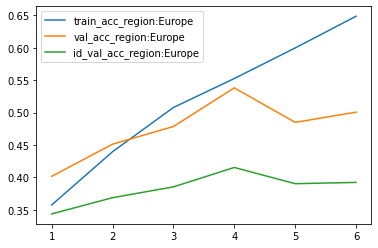

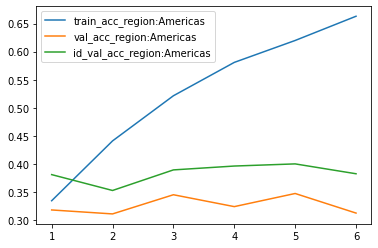

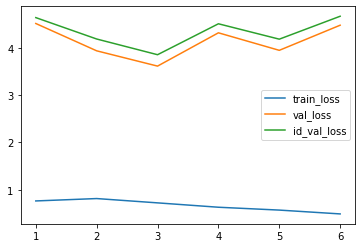

In [27]:
metrics = list(train_evolution[0].keys())

for metric in metrics:
	plot_graph(metric, train_evolution, val_evolution, id_val_evolution, len(train_evolution))